In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects


In [3]:
import pandas as pd

In [4]:
#path to deepfashion dataset
PATH = Path('/Deep/CAT_BB/')
JPEGS = 'img'

In [6]:
f = (PATH/'list_bbox.txt').open().readlines()[2:]

In [7]:
f[0].replace('                        ',' ').split()

['img/Sheer_Pleated-Front_Blouse/img_00000001.jpg', '072', '079', '232', '273']

In [8]:
bb = [row.replace('                        ',' ').split() for row in f]

In [9]:
for i,row in enumerate(bb):
    cat=row[0].split('/')[1].split('_')[-1]
    bb[i].extend([cat])

In [10]:
df = pd.DataFrame(bb,columns=['address','x_1','y_1','x_2','y_2','cat'])
df.x_1 = df.x_1.astype(int)
df.x_2 = df.x_2.astype(int)
df.y_1 = df.y_1.astype(int)
df.y_2 = df.y_2.astype(int)

In [11]:
df.cat.unique()

array(['Blouse', 'Blazer', 'Button-Down', 'Bomber', 'Anorak', 'Tee', 'Tank', 'Top', 'Sweater', 'Flannel',
       'Hoodie', 'Cardigan', 'Jacket', 'Henley', 'Poncho', 'Jersey', 'Turtleneck', 'Parka', 'Peacoat',
       'Halter', 'Skirt', 'Shorts', 'Jeans', 'Joggers', 'Sweatpants', 'Jeggings', 'Cutoffs', 'Sweatshorts',
       'Leggings', 'Culottes', 'Chinos', 'Trunks', 'Sarong', 'Gauchos', 'Jodhpurs', 'Capris', 'Dress',
       'Romper', 'Coat', 'Kimono', 'Jumpsuit', 'Robe', 'Caftan', 'Kaftan', 'Coverup', 'Onesie'], dtype=object)

In [12]:
cat_order = df.cat.value_counts().sort_values(ascending=False)
cat_to_downsample = cat_order[cat_order> 45000].index.values

In [13]:
downsample = df[df.cat.isin(cat_to_downsample)].groupby(
    'cat').apply(
    lambda v : v.iloc[random.sample(range(len(v)),45000)]).reset_index(drop=True)

In [14]:
cat_to_downsample

array(['Dress'], dtype=object)

In [15]:
df = pd.concat((df[~df.cat.isin(cat_to_downsample)],downsample)).sample(frac=1)

In [16]:
cat_to_merge = cat_order[cat_order<300].index.values

In [17]:
df['cat'] = df.cat.apply(lambda x : 'Other' if x in cat_to_merge else x)

In [18]:
cat_list = df.cat.unique()
cat_list.sort()


In [19]:
cat2ind = {cat:i for i,cat in enumerate(cat_list)}
ind2cat = {i:cat for i,cat in enumerate(cat_list)} 

In [20]:
df.cat = df.cat.apply(lambda x : cat2ind[x])

In [24]:
df.cat.max()

33

In [25]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [26]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [27]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [28]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [29]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [30]:
im_a = df[['y_1','x_1','y_2','x_2']].values


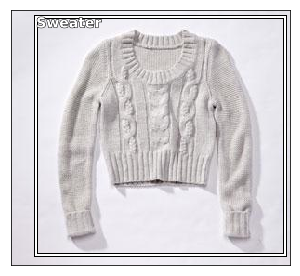

In [31]:
fig,ax = plt.subplots(figsize=(5,5))

num = 917
im = open_image(PATH/df.address.iloc[num])
ax = show_img(im,ax=ax)
b = bb_hw(im_a[num])
draw_rect(ax, b)
draw_text(ax, b[:2], ind2cat[df.iloc[num]['cat']])

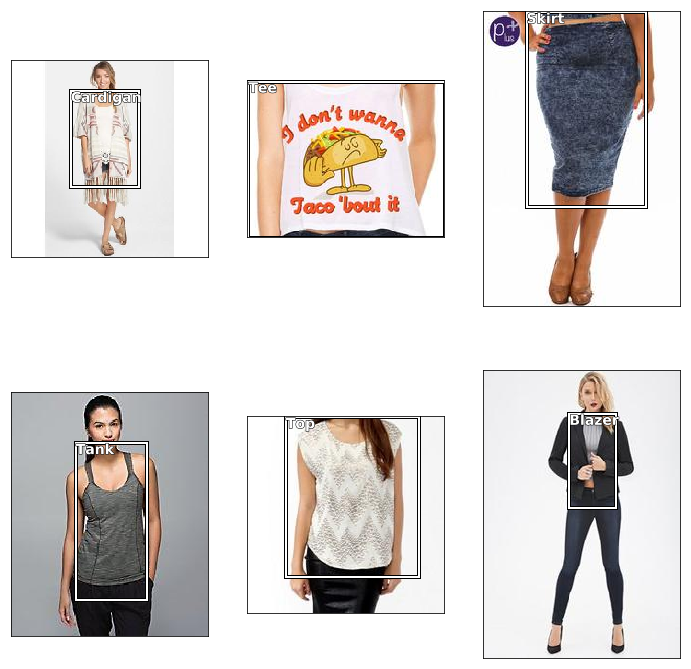

In [34]:
num_list = np.random.randint(0,len(df),6)
fig,axes = plt.subplots(2,3, figsize=(12,12))
for i,ax in enumerate(axes.flat):
    num = num_list[i]
    im = open_image(PATH/df.address.iloc[num])
    ax = show_img(im,ax=ax)
    b = bb_hw(im_a[num])
    draw_rect(ax, b)
    draw_text(ax, b[:2], ind2cat[df.iloc[num]['cat']])

In [35]:
(PATH/'tmp').mkdir(exist_ok=True)

In [36]:
BB = PATH/'tmp/bb.csv'
df['bb']=df.y_1.astype(str)+' '+df.x_1.astype(str)+' '+df.y_2.astype(str)+' '+df.x_2.astype(str)
df['full_add'] = df.address.apply(lambda x : x[4:])
df[['full_add','bb']].to_csv(BB,index=False)

In [37]:
BB.open().readlines()[:4]

['full_add,bb\n',
 'Faux_Leather_Grid_Shorts/img_00000007.jpg,182 77 257 202\n',
 'Paneled_Faux_Leather_Jacket/img_00000022.jpg,61 31 210 174\n',
 'Control_Sector_Drawstring_Harem_Joggers/img_00000050.jpg,1 95 255 205\n']

In [38]:
CSV = PATH/'tmp/cat.csv'
df[['full_add','cat']].to_csv(CSV,index=False)


In [39]:
CSV.open().readlines()[:4]

['full_add,cat\n',
 'Faux_Leather_Grid_Shorts/img_00000007.jpg,25\n',
 'Paneled_Faux_Leather_Jacket/img_00000022.jpg,13\n',
 'Control_Sector_Drawstring_Harem_Joggers/img_00000050.jpg,17\n']

In [40]:
len(CSV.open().readlines())

262065

In [41]:
f_model=resnet34
sz=224
bs=64
#f_model=resnext50
#sz=299
#bs=24

val_idxs = get_cv_idxs(len(df),val_pct=0.15)

In [44]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

In [45]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB, tfms=tfms,
   bs=bs, continuous=True, val_idxs=val_idxs)

In [46]:
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz) ,val_idxs=val_idxs)

In [47]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [48]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [49]:
val_ds2[0][1]

(array([  2.,  42., 221., 184.], dtype=float32), 33)

In [50]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [51]:
x,y=next(iter(md.val_dl))
idx=3
ima=md.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx])); b

array([ 99.,  86.,  30., 110.])

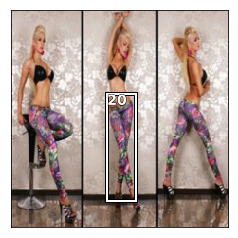

In [52]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][idx]])

[  0.  32. 223. 192.]
[ 20.  46. 163. 169.]
[ 39.  46. 163. 169.]
[ 38.  46. 164. 169.]
[  0.  37. 215. 187.]
[  0.  28. 213. 196.]
[  0.  31. 223. 193.]
[  0.  27. 214. 197.]
[  0.  31. 223. 193.]


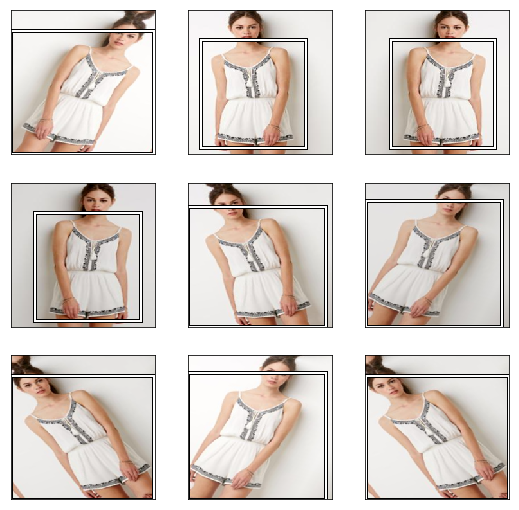

In [53]:
idx=4
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))

    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [54]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    #nn.Linear(2048,256),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cat2ind)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [55]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

In [57]:
learn.summary

<bound method ConvLearner.summary of Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),

 71%|███████   | 2477/3481 [09:54<04:00,  4.17it/s, loss=213] 

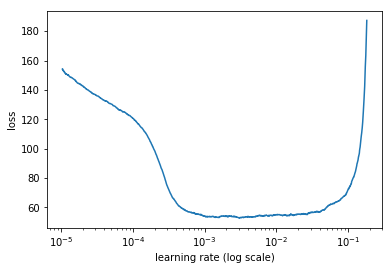

In [87]:
learn.lr_find()
learn.sched.plot()

In [89]:
lr = 3e-4

In [90]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5),best_save_name='bestmodel')

epoch      trn_loss   val_loss   detn_acc   detn_l1           
    0      49.884294  44.339088  0.549849   13.920985 
    1      46.867083  42.292011  0.565519   13.018748         
    2      46.043563  41.452574  0.571243   12.670033         


[array([41.45257]), 0.5712432267480327, 12.670032987968465]

In [91]:
learn.save('seri_1_lr_4e4')

In [92]:
learn.freeze_to(-2)

In [93]:
lrs = np.array([lr/50, lr/5, lr])

 75%|███████▌  | 2624/3481 [12:38<04:07,  3.46it/s, loss=176] 

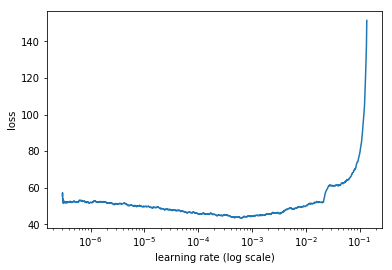

In [94]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [96]:
learn.fit(lrs/10, 1, cycle_len=5, use_clr=(32,10),best_save_name='bestmodel')

epoch      trn_loss   val_loss   detn_acc   detn_l1           
    0      42.711854  38.620165  0.609809   12.280887 
    1      40.147663  36.513755  0.630695   11.475815         
    2      39.350446  35.591499  0.63848    11.153333         
    3      37.690959  35.138511  0.64311    11.011517         
    4      37.570129  34.94523   0.645552   10.967576         


[array([34.94523]), 0.6455519092365314, 10.967575508362614]

In [97]:
learn.save('seri_2_unfreez_last_two')

In [98]:
learn.load('seri_2_unfreez_last_two')

In [99]:
learn.unfreeze()

 76%|███████▌  | 2634/3481 [15:18<04:55,  2.87it/s, loss=155] 

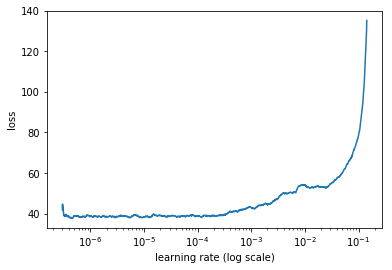

In [100]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [101]:
learn.fit(lrs/10, 1, cycle_len=12, use_clr=(32,10),best_save_name='bestmodel')

epoch      trn_loss   val_loss   detn_acc   detn_l1           
    0      37.732388  35.107165  0.645043   10.988647 
    1      36.959411  34.554104  0.65326    10.94058          
    2      36.508197  33.968016  0.657941   10.733004         
    3      35.533476  33.332309  0.66336    10.36048          
    4      36.424247  33.002888  0.663817   10.244759         
    5      34.109521  32.819129  0.666514   10.181417         
    6      33.398442  32.709199  0.668854   10.158471         
    7      33.577316  32.460472  0.669694   9.987891          
    8      33.742664  32.559946  0.670864   10.073387         
    9      33.227509  32.385104  0.673357   9.984026          
    10     33.065865  32.40117   0.672187   9.966506          
    11     33.103929  32.315975  0.673612   9.966421          


[array([32.31597]), 0.6736116411045515, 9.966420998153952]

In [108]:
learn.save('seri_3_unfreez_full')

In [109]:
learn.load('seri_3_unfreez_full')

In [110]:
learn.fit(lrs/15, 1, cycle_len=15, use_clr=(40,10),best_save_name='bestmodel2')

epoch      trn_loss   val_loss   detn_acc   detn_l1           
    0      33.2961    32.49711   0.672416   10.100569 
    1      33.487573  32.333256  0.672874   9.906647          
    2      32.797596  32.184849  0.6744     9.832773          
    3      32.146159  32.187003  0.675952   9.893406          
    4      31.715873  32.101153  0.675036   9.834258          
    5      30.808329  32.060463  0.676385   9.808443          
    6      31.518291  32.108751  0.676792   9.824149          
    7      30.739102  32.178088  0.676766   9.854406          
    8      30.492867  32.016199  0.676461   9.686514          
    9      30.310105  31.986185  0.676435   9.647362          
    10     30.582331  31.974457  0.677326   9.653211          
    11     29.650757  31.990211  0.676919   9.643467          
    12     30.146638  31.933545  0.677911   9.617136          
    13     29.962411  32.018253  0.677122   9.649966          
    14     30.726778  32.08256   0.6773     9.706573          


[array([32.08256]), 0.677300363788924, 9.706573226371873]

In [153]:
#learn.save('seri_4_unfreez_full')

In [111]:
learn.load('bestmodel2')

In [112]:
y = learn.predict()


In [175]:
iter_x = iter(md.val_dl)
x,_ = next(iter_x)
x,_ = next(iter_x)
x,_ = next(iter_x)
x,_ = next(iter_x)

base = 64 *3

In [170]:
from scipy.special import expit

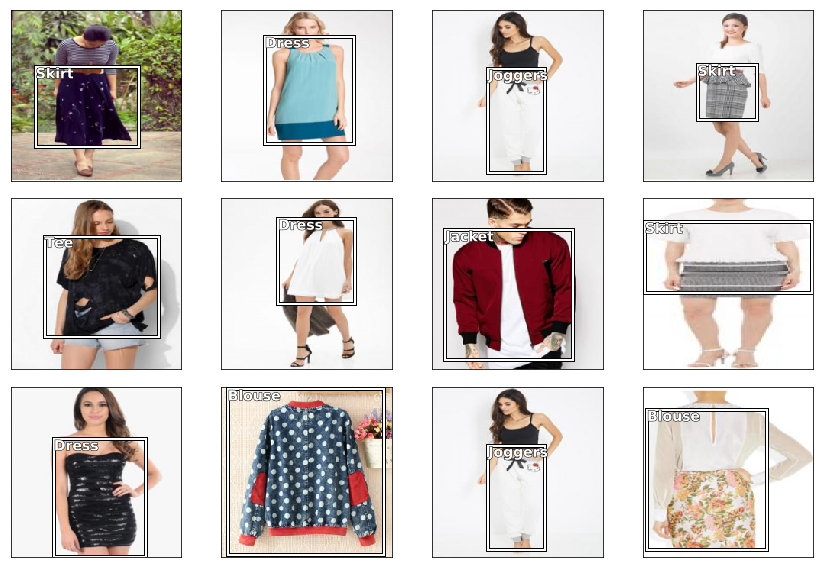

In [176]:
num_list = np.random.randint(0,63,12)
#num_list = range(0,12)
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    num = num_list[i]
    ima=md.val_ds.ds.denorm(to_np(x))[num]
    bb = expit(y[base+num][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[num+base][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], ind2cat[int(md2.classes[c])])
    #ax.title.set_text(ind2c)
plt.tight_layout()